## Global


In [288]:
asap_project_id = 'ASAP-EVD68-3CLPRO'
xchem_project_id = 'D68EV3CPROA'

# column names as will be used for upload

labels = {'SMILES': 'SMILES',
         'XChem code': f'fragment_XChem-code',
         'method': 'fragment_method-name',
         'notes': 'fragment_notes',
         'keywords': 'fragment_method-keywords',
         'date': f'fragment_method-date',
         'institution': f'fragment_submitter_institution',
         'name': f'fragment_submitter_name',
         'email': f'fragment_submitter_email',
         'ref XChem': f'fragment_reference_XChem',
         'ref vcid': f'fragment_reference_vcid',
         'ref SMILES': f'fragment_reference_SMILES',
         }

## Deal with XChem to ASAP conversion

Xref XChem to ASAP to make `xchem2asap.json`
Requires the upload of the hits or Screening library

In [92]:
metadata = pd.read_csv('D68EV3CPROA_metadata.csv')
metadata['RealCrystalName'] = metadata.RealCrystalName.str.replace('D68EV3CPROA-', '')
xchem2smiles: pdt.Series[str]  = metadata.drop_duplicates('RealCrystalName').set_index('RealCrystalName').new_smiles.str.replace('Cl.','')
xchem2mol: pdt.Series[Chem.Mol] = xchem2smiles.apply(Chem.MolFromSmiles)
xchem2fp: pdt.Series[DataStructs] = xchem2mol.apply(functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3))
originals: List[str] = metadata.loc[~metadata.alternate_name.str.contains('ASAP')].RealCrystalName.to_list()

In [250]:
import pandas as pd
import pandera.typing as pdt
import functools
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, DataStructs
from typing import List


asapt: pd.DataFrame =  pd.concat([pd.read_csv('submission-ASAP-DESIGN-996.csv'),
                                  pd.read_csv('submission-ASAP-DESIGN-987.csv'),
                                  pd.read_csv('submission-ASAP-DESIGN-990.csv')])

asap2smiles: pdt.Series[str] = asapt.drop_duplicates('SMILES').set_index('vc_id_postera').original_query
asap2mol: pdt.Series[Chem.Mol] = asap2smiles.apply(Chem.MolFromSmiles)
asap2fp: pdt.Series[DataStructs] = asap2mol.apply(functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3))

In [251]:
xchem2asap = {}
missing = []

for xchem_code, xchem_fp in xchem2fp.items():
    if xchem_code not in originals:
        continue
    for asap_code, asap_fp in asap2fp.items():
        if xchem_fp == asap_fp:
            xchem2asap[xchem_code] = asap_code
            break
    else:
        missing.append(xchem_code)

In [ ]:
if missing:
    pd.DataFrame({labels['XChem code']: missing,
                  labels['method']: 'XChem initial screen',
                  labels['notes']: 'unidentified library',
                  'SMILES': [xchem2smiles[code] for code in missing]})\
      .to_csv('missing_codes.csv', index=False)
    print('Please upload')
else:
    print('All good now')

COCCN(C)S(=O)(=O)NCc1ccc2c(c1)OCO2


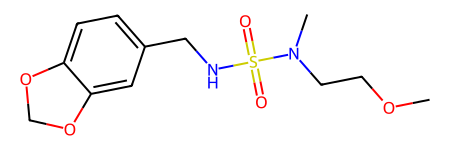

In [253]:
print( xchem2smiles['x2021'] )
xchem2mol['x2021'] 

In [254]:
xchem2asap['x2099'] = 'ASAP-VC-5892'
xchem2asap['x1919'] = 'ASAP-VC-6113'
xchem2asap['x2149'] = 'ASAP-VC-7470'
xchem2asap['x2021'] = 'ASAP-VC-6077'
xchem2asap[''] = ''
xchem2asap[''] = ''

In [255]:
import json

with open('xchem2asap.json', 'w') as fh:
    json.dump(xchem2asap, fh)

## Conflict test
I think this did not delete previous vcid

In [256]:
import pandas as pd

libraries = pd.read_csv('combined-XChem-libraries.csv', index_col=0)
reduced  =  libraries.drop_duplicates(['SMILES', 'library']) \
                     .groupby('SMILES').agg({'library': ','.join, 
                                             'Id':set }) \
                     .reset_index()
reduced['Id'] = reduced['Id'].apply(','.join)
# reduced['designer_institution'] = 'XChem'
# reduced['design_rationale'] = 'XChem initial soak'
# reduced['design_submission_source_link'] = 'https://www.diamond.ac.uk/industry/Techniques-Available/Integrated-Structural-Biology/Fragment-Screening---XChem/Fragment-Libraries.html'
# reduced['designer_name'] = 'XChem team'
# reduced['design_notes'] = 'Fragment libraries: '+reduced.design_notes
reduced['FP'] = reduced.SMILES.apply(Chem.MolFromSmiles).apply(functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3))

In [257]:
xchem2libary = {}

originals = list(set(originals))
for code in originals:
    matched = reduced.loc[xchem2fp[code] == reduced.FP]
    if len(matched):
        xchem2libary[code] = matched.library.iloc[0]
    else:
        xchem2libary[code] = 'unknown'
        
pd.DataFrame({labels['XChem code']: originals,
              labels['method']: 'XChem initial screen',
              labels['notes']: [xchem2libary[code] for code in originals],
              labels['keywords']: 'screen',
              labels['institution']: 'DLS XChem',
              labels['date']: '01-01-2001',
              'SMILES': [xchem2smiles[code] for code in originals]})\
      .to_csv('xstal.csv', index=False)

## Fix Csets

A compound set is a right hand side upload in fragalysis.
I.e. submitted virtual compounds

In [ ]:
import requests
import pandas as pd
import operator
import os
from pathlib import Path

available = [datapath.name for datapath in Path('media_compounds_sets').glob('*.sdf')]

cset_metadata = pd.DataFrame( requests.get('https://fragalysis.diamond.ac.uk/api/compound-sets/').json()['results'] )
targets = pd.DataFrame( requests.get('https://fragalysis.diamond.ac.uk/api/targets/').json()['results'] )
id2name = targets.set_index('id').title.to_dict()
cset_metadata['target_name'] = cset_metadata.target.map(id2name)
cset_metadata['sdf_name'] = cset_metadata.submitted_sdf.fillna('').apply(os.path.split).apply(operator.itemgetter(-1))
cset_metadata['locally_available'] = cset_metadata['sdf_name'].isin(available)

In [290]:
print('These are unavailable')
cset_metadata.loc[(cset_metadata.target_name == 'D68EV3CPROA') & ~cset_metadata.locally_available].unique_name.to_list()

These are unavailable


['StephWills-fragnetv1',
 'LucyVost-STRIFE-fragmentelaboration',
 'PDB-StolenfromPDB']

In [ ]:
output_path = Path('output')
output_path.mkdir(exist_ok=True)

def desufficify(xchem_codes: str):
    return xchem_codes.split('_')[0]

def convert_codes_to_asap(xchem_codes: str):
    return ' '.join([xchem2asap[desufficify(xchem_code)] for xchem_code in xchem_codes.split(',')])

def convert_codes_to_smiles(xchem_codes: str):
    return '.'.join([xchem2smiles[desufficify(xchem_code)] for xchem_code in xchem_codes.split(',')])

fixer_uppers = cset_metadata.loc[(cset_metadata.target_name == xchem_project_id) & cset_metadata.locally_available]

csets = {}
for i, row in fixer_uppers.iterrows():
    cset = PandasTools.LoadSDF((Path('media_compounds_sets') / row.sdf_name).as_posix(), smilesName='SMILES', embedProps=True)
    header = cset.iloc[0]
    cset = cset.iloc[1:].copy()
    if len(cset) == 0:
        print(row.unique_name, 'EMPTY')
        continue
    if 'STRIFE' in row.unique_name:
        keywords = 'STRIFE,de-novo,AI,analog-by-catalog'
    elif 'fragnet' in row.unique_name.lower():
        keywords = 'fragnet,catalog-enumeration,linker,substructure-based'
    elif 'ROCS' in row.unique_name:
        keywords = 'ROCS,shape&color,catalog-enumeration'
    elif 'Manual' in row.unique_name:
        keywords = 'by-eye'
    elif 'Arthor' in row.unique_name:
        keywords = 'Arthor,catalog-enumeration,linker'
    elif 'Fragmenstein' in row.unique_name:
        keywords = 'Fragmenstein,de-novo,merger,analog-by-catalog,linker'
    else:
        raise ValueError(row.unique_name)
    cset[labels['keywords']] = keywords
    cset[labels['method']] = header.method
    cset[labels['name']] = header.submitter_name
    cset[labels['email']] = header.submitter_email
    cset[labels['institution']] = header.submitter_institution
    cset[labels['date']] = header.generation_date
    cset[labels['ref XChem']] = cset.ref_mols
    cset[labels['ref vcid']] = cset.ref_mols.apply(convert_codes_to_asap)
    cset[labels['ref SMILES']] = cset.ref_mols.apply(convert_codes_to_smiles)
    cset[labels['notes']] = row.unique_name
    
    
    munged = cset[[col for col in cset.columns if col in labels.values()]]
    
    cset['fp'] = cset.ROMol.apply(functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3))
    for xchem_code, xchem_fp in xchem2fp.items():
            matched = cset['fp'] == xchem_fp
            if matched.any():
                print(xchem_code)
                munged.loc[matched, labels['XChem code']] = xchem_code
    
    csets[row.unique_name] = cset.copy()
                
    print('\n\n****************')
    print(f'P2. Design wave 1. Fragalysis upload by {header.submitter_name} ("{row.unique_name}")')
    print(' '.join(set(munged[labels['ref vcid']].to_list())))

    munged.fillna('').to_csv(output_path / (row.unique_name + '.csv'), index=False)

## Fix Beth's sheet

In [384]:
import pandas as pd

quote = pd.read_csv('PosteraPreUploadWithSubstitutionsElaboratedQuote_1753205_subs.csv')
quote = quote.loc[~quote.SMILES.isna()].copy()
quote['mol'] = quote.SMILES.apply(Chem.MolFromSmiles)
quote['fp'] = quote.mol.apply(functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3))

In [385]:
matched = []
for i, row in quote.iterrows():
    for cset_name, cset in csets.items():
        mask = cset.fp == row.fp
        if not any(mask):
            continue
        matched.append( cset.loc[mask].iloc[0] )
        break
    else:
        print(row)
        matched.append( pd.Series() )
        
matched = pd.DataFrame( matched ).reset_index()
matched[[c for c in matched.columns if c in labels.values()]].to_csv('to_order.csv', index=False)

In [386]:
len(matched), len(quote)

(126, 126)

In [387]:
replaced = matched.loc[(~quote.reset_index().Substitution.isna()).to_list()].copy()
labels['order info'] = 'fragment_order_info'
replaced[labels['order info']] = 'replaced'
replaced[[c for c in replaced.columns if c in labels.values()]].to_csv('replaced.csv', index=False)

## Manual Ops
The above was uploaded and dowlanded as ASAP-DESIGN-1006

In [388]:
#matched.loc[(~quote.reset_index().Substitution.isna()).to_list(), 'fragment_order_info'] = 'replaced'
#matched.loc[(~quote.reset_index().Substitution.isna()).to_list(), 'fragment_order_info'] 

In [389]:
# original_query is not the original, nor is SMILES uppercase is.
replaced_smiles2vcids = pd.read_csv('submission-ASAP-DESIGN-1006.csv').set_index('SMILES').vc_id_postera.to_dict()

In [390]:
matched['VCID'] = matched.SMILES.map(replaced_smiles2vcids)

In [446]:
munged = pd.concat([quote, matched.drop(columns=['SMILES'])], axis=1)
mask = ~munged.Substitution.isna()
munged.loc[mask, labels['keywords']] = 'analog-by-catalog'
munged.loc[mask, labels['method']] = 'Enamine order substition of ' + munged.loc[mask, labels['method']]
munged.loc[mask, labels['ref vcid']] = munged.loc[mask, 'VCID']
munged.loc[mask, labels['ref SMILES']] = munged.loc[mask, 'SMILES']
munged.loc[mask, labels['ref XChem']] = ''
munged.loc[mask, 'SMILES'] = munged.loc[mask,' Substitution SMILES'].apply(lambda s: s.split('>>')[-1])
munged.loc[mask, 'Catalog ID'] = munged[mask]['Substitution']
for k in ('Collection','Price, USD','Lead time'):
    munged.loc[mask, k] = munged.loc[mask, f'{k}.1']
    
munged.loc[munged[labels['institution']] == 'Nowhere',labels['institution']] = 'University of Oxford'
munged['SMILES'] = munged.SMILES.str.strip()

wanted_cols = ['SMILES', 'Catalog ID', 'Purity, %', 'Amount, mg', 'Stock Available',
       'Collection', 'Price, USD', 'Lead time'] + [c for c in munged.columns if c in labels.values() and c not in ('SMILES',)]
assert munged.SMILES.apply(Chem.MolFromSmiles).astype(bool).all(), 'Invalid SMILES!'
munged[wanted_cols].to_csv('to_order.csv', index=False)

In [464]:
import contextlib

# xchem2mol: pdt.Series[Chem.Mol] = xchem2smiles
# xchem2fp: pdt.Series[DataStructs] = xchem2mol.apply(functools.partial(AllChem.GetMorganFingerprintAsBitVect, radius=3))
def to_fp(smiles):
    with contextlib.suppress(Exception):
        mol = Chem.MolFromSmiles(smiles)
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3)
    return None
        

soaked = pd.read_csv('EVD68_3C-Protease_SBC_Analysis - Compound Tracker.csv')
soaked['FP'] = soaked['Modelled SMILES'].apply(to_fp)

[09:20:40] SMILES Parse Error: syntax error while parsing: Solvent
[09:20:40] SMILES Parse Error: Failed parsing SMILES 'Solvent' for input: 'Solvent'
[09:20:40] SMILES Parse Error: syntax error while parsing: -
[09:20:40] SMILES Parse Error: Failed parsing SMILES '-' for input: '-'
[09:20:40] SMILES Parse Error: syntax error while parsing: -
[09:20:40] SMILES Parse Error: Failed parsing SMILES '-' for input: '-'
[09:20:40] SMILES Parse Error: syntax error while parsing: -
[09:20:40] SMILES Parse Error: Failed parsing SMILES '-' for input: '-'
[09:20:40] SMILES Parse Error: syntax error while parsing: -
[09:20:40] SMILES Parse Error: Failed parsing SMILES '-' for input: '-'
[09:20:40] SMILES Parse Error: syntax error while parsing: Replace
[09:20:40] SMILES Parse Error: Failed parsing SMILES 'Replace' for input: 'Replace'


In [489]:
matched = []

def match(fp, blank=['No match']) -> pd.Series:
    if fp is None:
        return pd.Series({'fragment_notes': 'Invalid SMILES'})
    for i, frag in reduced.iterrows():
        if frag.FP == fp:
            frag['fragment_notes'] = frag.library
            blank.append('Unknown library')
            return frag
    for cset_name, cset in csets.items():
        mask = cset.fp == fp
        if any(mask):
            return cset.loc[mask].iloc[0]
    return pd.Series({'fragment_notes': blank[-1]})
    
    

matched: pd.DataFrame = soaked.FP.apply(match)

#pd.DataFrame( .to_list() ).reset_index()
#matched[[c for c in matched.columns if c in labels.values()]].to_csv('to_order.csv', index=False)


In [542]:
def fix(row):
    if row.name < 305:
        return row
    elif row.name > 360:
        return row
    elif row.fragment_notes == 'No match':
        row['fragment_notes'] = 'Other P2'
        return row
    else:
        return row

matched = matched.apply(fix, axis=1)

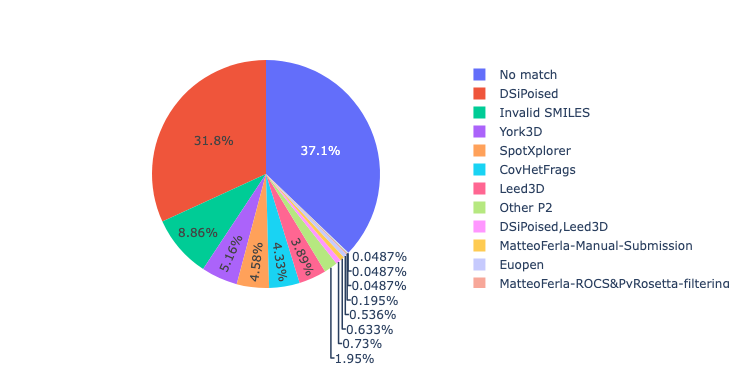

In [543]:
import plotly.express as px

px.pie( matched, 'fragment_notes')

In [544]:
# M
matched['status'] = soaked['Compound status'].to_list() 
matched['modelled_SMILES'] = soaked['Modelled SMILES'].to_list() 

In [545]:
matched.loc[matched.SMILES.isna(), 'SMILES'] = matched.loc[matched.SMILES.isna(), 'modelled_SMILES']

In [546]:
matched[['SMILES', 'fragment_notes', 'status']]

,SMILES,fragment_notes,status
0,Solvent entries for 3 time points,Invalid SMILES,Analysis in progress
1,NaN,Invalid SMILES,Analysis in progress
2,-,Invalid SMILES,Analysis in progress
3,-,Invalid SMILES,Analysis in progress
4,-,Invalid SMILES,Analysis in progress
...,...,...,...
2049,CCn1cc(CCO)cn1,DSiPoised,Analysis in progress
2050,CC1CNCCN1CCO,DSiPoised,Analysis in progress
2051,CNc1nccnc1C#N,DSiPoised,Analysis in progress
2052,Cc1cc(C)c(NC(=O)CO)c(C)c1,DSiPoised,Analysis in progress


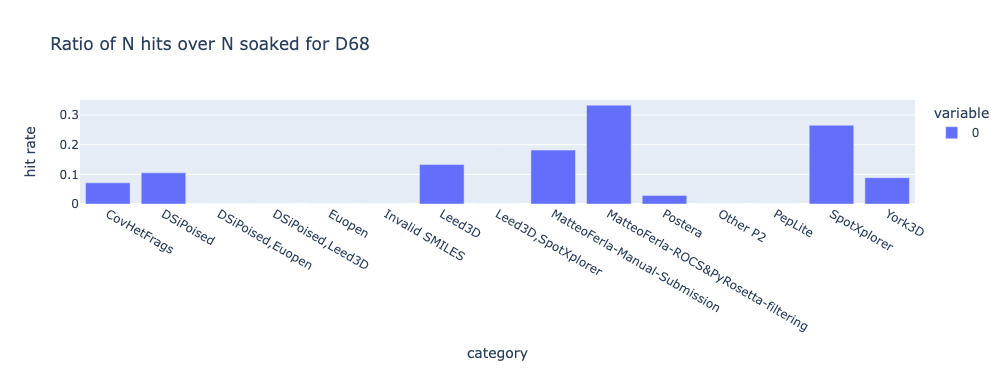

In [561]:
#matched[['SMILES', 'fragment_notes', 'status']]

pivotted = pd.DataFrame.pivot_table(matched,
                                    columns='fragment_notes',
                                    values='SMILES',
                                    index='status', aggfunc=len)\
                       .fillna(0).astype(int)\
                       .rename(columns={'No match': 'Postera'})

#pivotted.loc['Completed - structure released']

fig = px.bar(pivotted.loc['Completed - structure released'] / pivotted.loc['Analysis in progress'],
      title='Ratio of N hits over N soaked for D68')
fig.update_layout(yaxis=dict(title='hit rate'), xaxis=dict(title='category'))
fig

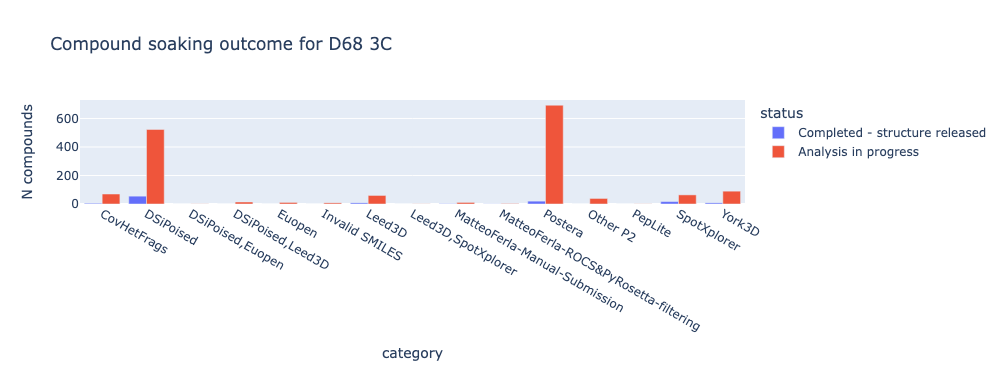

In [563]:
fig = px.bar(pivotted.transpose()[['Completed - structure released', 'Analysis in progress']],
      title='Compound soaking outcome for D68 3C'
      )
fig.update_layout(barmode='group')
fig.update_layout(yaxis=dict(title='N compounds'), xaxis=dict(title='category'))

fig

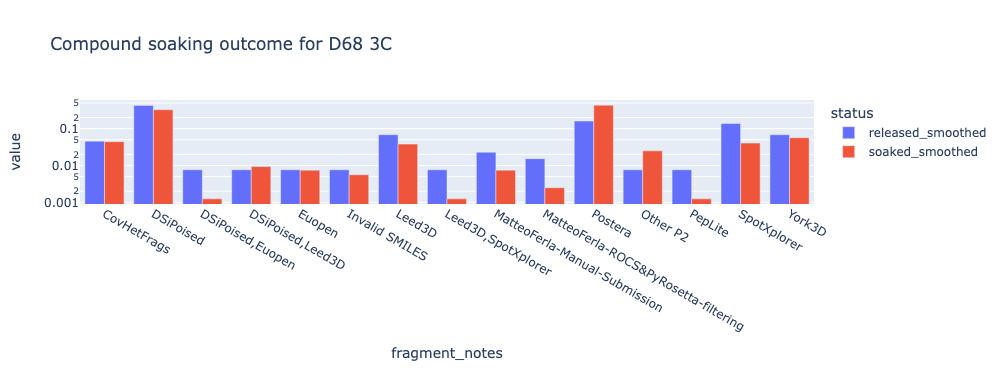

In [564]:
def laplace_smooth(series, alpha=1):
    """Laplace smoothing of a pandas Series."""
    # Total count of all categories
    N = series.sum()
    # Number of unique categories
    K = len(series)
    # Apply Laplace smoothing formula
    smoothed = (series + alpha) / (N + alpha * K)    
    return smoothed

pivotted.loc['soaked_smoothed'] = laplace_smooth(pivotted.loc['Analysis in progress'])
pivotted.loc['released_smoothed'] = laplace_smooth(pivotted.loc['Completed - structure released'] )

fig = px.bar(pivotted.transpose()[['released_smoothed', 'soaked_smoothed']],
      title='Compound soaking outcome for D68 3C', log_y=True
      )
fig.update_layout(barmode='group')
fig

In [534]:
pd.concat([soaked.reset_index(drop=True),
           matched.reset_index(drop=True)],
         axis=1,
         ).to_csv('soak_annotated.csv')

In [478]:
def categorize(row):
    if str(row.error) != 'nan':
        row.fragment_notes = row.error
        return row.error
    elif str(row.library) != 'nan':
        row.fragment_notes = row.library
        return row.library
    elif str(row.fragment_notes) != 'nan':
        return row.
    else:
        raise ValueError
    
matched['category'] = matched.apply(categorize, axis=1)